In [236]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import string

import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

# Import matplotlib for 3d plotting:
import matplotlib.pyplot as plt
from matplotlib import colors
# Make matplotlib work in jupyter notebook
%matplotlib inline

In [237]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

In [238]:
data = pd.read_csv('/kaggle/input/marketingcampaign/marketing_campaign.csv' , sep = '\t')

In [239]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [240]:
data.head

<bound method NDFrame.head of          ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
0            0  04-09-2012      

In [241]:
data = data.dropna()

In [242]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"] , format = "%d-%m-%Y")
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

In [243]:
data = data.dropna()

In [244]:
data["Age"] = 2024-data["Year_Birth"]
data = data.drop("Year_Birth",axis=1)

In [245]:
days = []
d1 = max(dates) 
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [246]:
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})
data["Children"]=data["Kidhome"]+data["Teenhome"]
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue","ID"]
data = data.drop(to_drop, axis=1)

In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   object 
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   int64 

<Figure size 800x550 with 0 Axes>

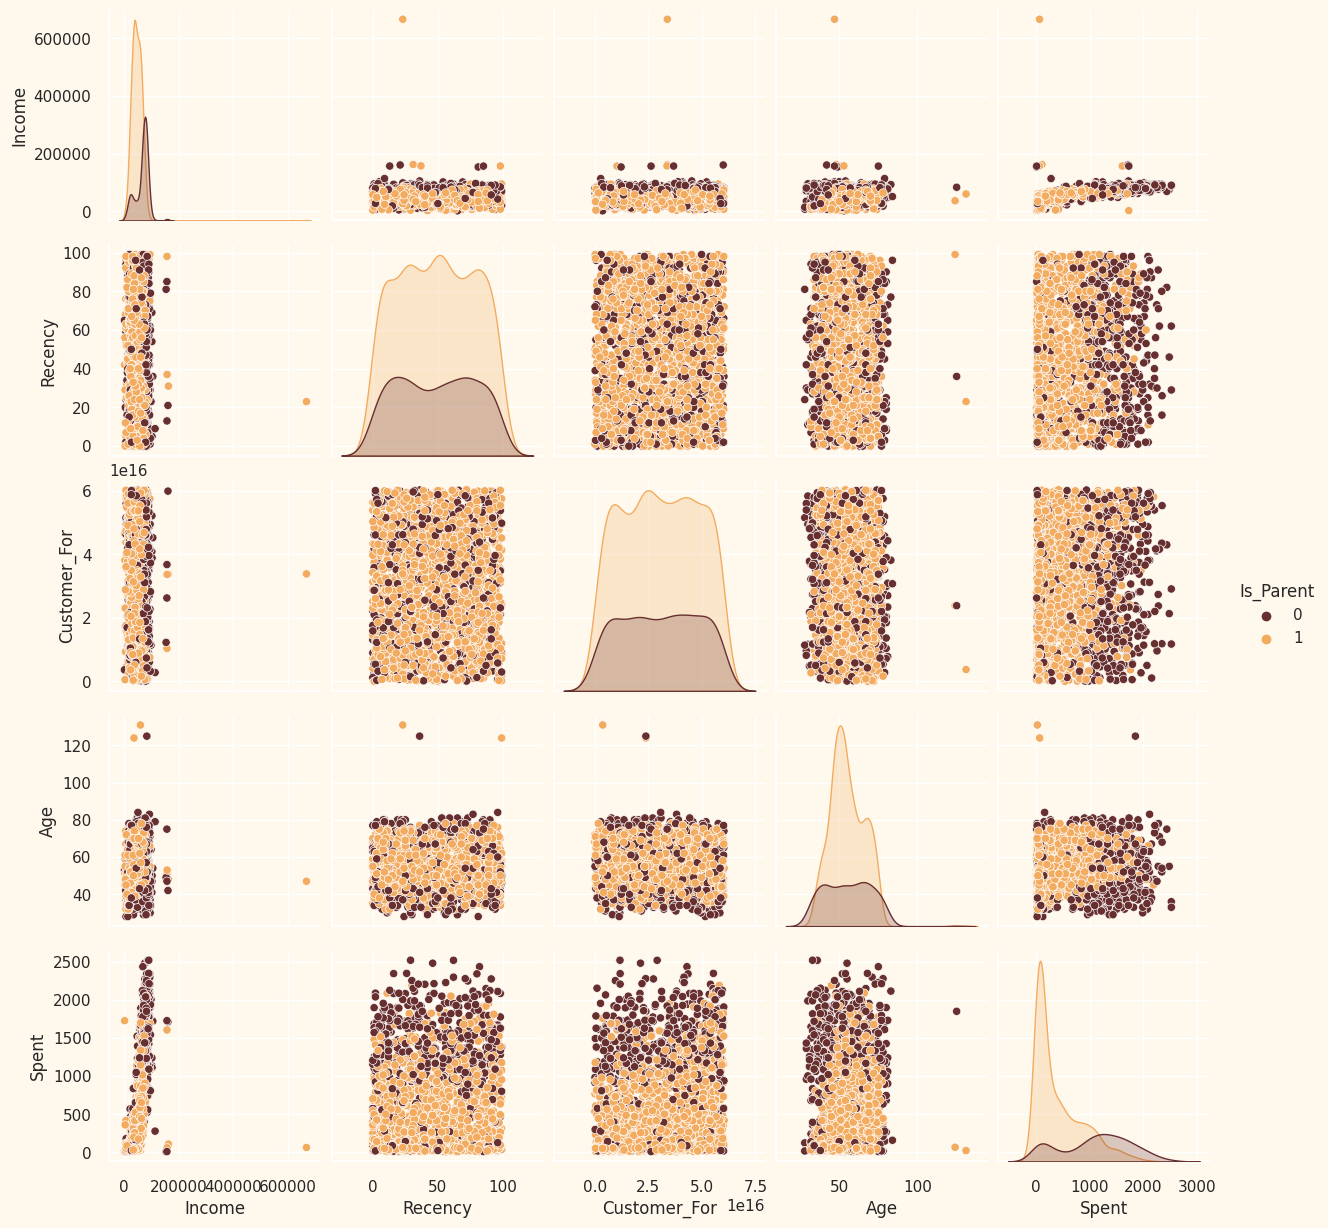

In [248]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"])) 
plt.show()

In [249]:
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]

In [250]:
obj_col = ["Education","Living_With"]
LE=LabelEncoder()
for i in obj_col:
    data[i]=data[[i]].apply(LE.fit_transform)

In [251]:
df = data.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response'],axis=1)
scaler = StandardScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df),columns= df.columns )

In [252]:
df.head

<bound method NDFrame.head of       Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0     -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1     -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2     -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3     -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4      0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   
...         ...       ...       ...       ...       ...       ...       ...   
2207  -0.893586  0.430444 -0.822754  0.908097 -0.104347  1.197084  0.419540   
2208   0.571657  0.560123  2.902796  0.908097  0.241237  0.298631 -0.662628   
2209  -0.893586  0.233347 -0.822754 -0.929699  1.450778  1.787156  0.545373   
2210   0.571657  0.803172 -0.822754  0.908097 -1.417564  0.363866  0.092373   
2211   0.571657  0.042290  1.040021  0.908097 -0.311697 -0.656159 -0.587128   

          Meat      F

In [253]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def scorer(pcamodel, df, y=None):

    try:
        X_val = df.values
    except:
        X_val = df
        
    # Calculate and inverse transform the data
    data_inv = pcamodel.fit(X_val).transform(X_val)
    data_inv = pcamodel.inverse_transform(data_inv)
    
    # The error calculation
    mse = mean_squared_error(data_inv.ravel(), X_val.ravel())
    
    # Larger values are better for scorers, so take negative value
    return -1.0 * mse

# The grid search parameters
param_grid = {'gamma':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0],
              'n_components': [2, 3, 4]}

# The grid search
kernelPCA = GridSearchCV(KernelPCA(kernel='rbf', fit_inverse_transform=True),
                         param_grid=param_grid,
                         scoring=scorer,
                         n_jobs=-1)


kernelPCA = kernelPCA.fit(df)

kernelPCA.best_estimator_

KernelPCA(fit_inverse_transform=True, gamma=0.05, kernel='rbf', n_components=4)

In [254]:
pca = KernelPCA(fit_inverse_transform=True, gamma=0.05, kernel='rbf', n_components=4)
pca.fit(df)
PCA_ds = pd.DataFrame(pca.transform(df), columns=(["col1","col2", "col3","col4"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,2.208400e-17,0.316714,-0.515615,-0.313025,-0.012564,0.310387,0.555640
col2,2212.0,-8.030546e-18,0.225640,-0.372333,-0.201647,-0.037876,0.203661,0.522475
col3,2212.0,-2.108018e-17,0.188270,-0.388967,-0.162282,-0.016752,0.136108,0.536994
col4,2212.0,-6.424437e-18,0.173195,-0.512151,-0.109061,-0.003248,0.102612,0.537152


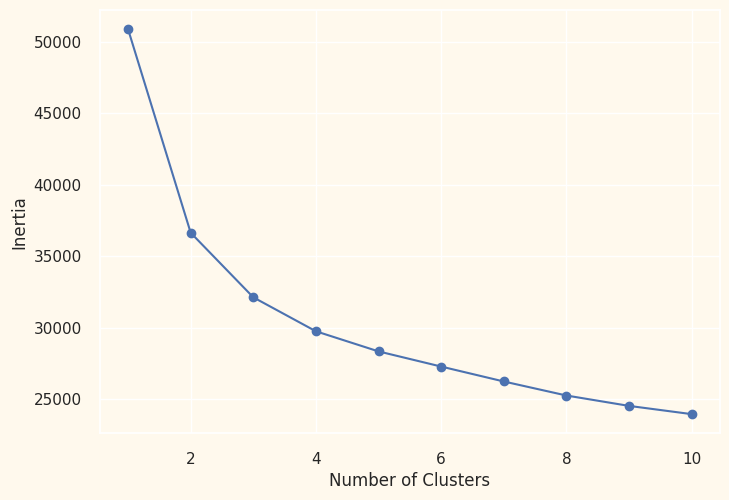

In [255]:
from sklearn.cluster import KMeans
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(df)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [256]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans_model.fit_predict(df)
silhouette_avg = silhouette_score(df, kmeans_labels)
db_index = davies_bouldin_score(df, kmeans_labels)
inertia = kmeans_model.inertia_

In [257]:
scores = pd.DataFrame(columns = ['Model','Silhouette Score','Davies-Bouldin Index'])
scores = scores._append({'Model': ['Kmeans'] ,'Silhouette Score':[silhouette_avg] , 'Davies-Bouldin Index': [db_index]}, ignore_index = True)

In [258]:
AC = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
yhat_AC = AC.fit_predict(df)
silhouette_avg = silhouette_score(df, yhat_AC)
db_index = davies_bouldin_score(df, yhat_AC)
scores = scores._append({'Model': ['AgglomerativeClustering'] ,'Silhouette Score':[silhouette_avg] , 'Davies-Bouldin Index': [db_index]}, ignore_index = True)

In [259]:
scores

,Model,Silhouette Score,Davies-Bouldin Index
0,[Kmeans],[0.15481196455262164],[1.8969511876148382]
1,[AgglomerativeClustering],[0.13674461568396834],[1.8970419653271753]


In [260]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
ms = MeanShift()
model = ms.fit(df)
labels = ms.labels_
bandwidth = estimate_bandwidth(df, quantile=0.3, n_samples=300)
ms = MeanShift(bandwidth=bandwidth)
dfm = ms.fit_predict(df)

In [261]:
silhouette_avg = silhouette_score(df, dfm)
db_index = davies_bouldin_score(df, dfm)
scores = scores._append({'Model': ['MeanShift'] ,'Silhouette Score':[silhouette_avg] , 'Davies-Bouldin Index': [db_index]}, ignore_index = True)

In [263]:
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [3, 5, 10]

best_silhouette = -1
best_params = {}

for eps_val in eps_values:
    for min_samples_val in min_samples_values:
        dbscan_model = DBSCAN(eps=eps_val, min_samples=min_samples_val)
        cluster_labels = dbscan_model.fit_predict(df)

        # Exclude noise points (-1) from silhouette score calculation
        if len(set(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(df, cluster_labels)
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_params = {'eps': eps_val, 'min_samples': min_samples_val}

print("Best parameters:", best_params)

Best parameters: {'eps': 1.0, 'min_samples': 5}


In [264]:
dbscan_model = DBSCAN(eps=1.0, min_samples=5)
db = dbscan_model.fit_predict(df)
silhouette_avg = silhouette_score(df, db)
db_index = davies_bouldin_score(df, db)
scores = scores._append({'Model': ['DBSCAN'] ,'Silhouette Score':[silhouette_avg] , 'Davies-Bouldin Index': [db_index]}, ignore_index = True)

In [265]:
scores

,Model,Silhouette Score,Davies-Bouldin Index
0,[Kmeans],[0.15481196455262164],[1.8969511876148382]
1,[AgglomerativeClustering],[0.13674461568396834],[1.8970419653271753]
2,[MeanShift],[0.22982074132544394],[0.6540106086998878]
3,[DBSCAN],[-0.1996721373416485],[1.4448565224432899]
